In [51]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

In [52]:
# Check if device supports CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using: " + str(device))

using: cuda


In [53]:
# define transformation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((300, 300))

])

Image information:

dimension: 300 x 300
bit depth: 24 (rgb - 3 x 8 bits)

In [54]:
# import dataset
original_train_dataset = datasets.ImageFolder("traindata", transform=train_transform)

# create validation set for better training (and because I don't have the test set)
train_set, val_set = random_split(original_train_dataset, [3600, 900], generator=torch.Generator().manual_seed(7))

# create loaders
desired_batch_size = 2

train_loader = torch.utils.data.DataLoader(train_set, batch_size=desired_batch_size, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=desired_batch_size, shuffle=True, num_workers=2)

classes = ("cherry", "strawberry", "tomato")

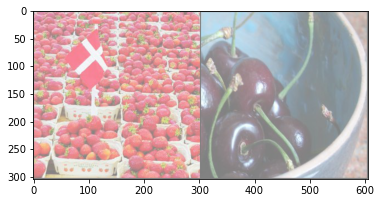

strawberry cherry


In [55]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(desired_batch_size)))

In [56]:
# define our CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 30, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 16, 5)
        self.fc1 = nn.Linear(82944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(30, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [57]:
# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.8)

In [58]:
# iterate over the dataset

min_valid_loss = np.inf
for epoch in range(30):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    valid_loss = 0.0
    # cnn_model.eval()
    # for data, labels in val_loader:
    #
    #     # Forward Pass
    #     target = cnn_model(data)
    #     # Find the Loss
    #     loss = criterion(target, labels)
    #     # Calculate Loss
    #     valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: { train_loss / len(train_loader) } \t\t Validation Loss: { valid_loss / len(val_loader) }')

    # if min_valid_loss > valid_loss:
    #     print(f'Validation Loss Decreased { min_valid_loss } --> { valid_loss }')
    #     min_valid_loss = valid_loss
    #     torch.save(cnn_model.state_dict(), "model.pth")


print('Finished Training')

Epoch 1 		 Training Loss: 1.1681761176387468 		 Validation Loss: 0.0
Epoch 2 		 Training Loss: 1.064888372545441 		 Validation Loss: 0.0
Epoch 3 		 Training Loss: 1.0167669280949565 		 Validation Loss: 0.0
Epoch 4 		 Training Loss: 0.9910561804225048 		 Validation Loss: 0.0
Epoch 5 		 Training Loss: 0.9509303459649284 		 Validation Loss: 0.0
Epoch 6 		 Training Loss: 0.9253739201049838 		 Validation Loss: 0.0
Epoch 7 		 Training Loss: 0.8902088513452974 		 Validation Loss: 0.0
Epoch 8 		 Training Loss: 0.8416330238845613 		 Validation Loss: 0.0
Epoch 9 		 Training Loss: 0.7775177733481138 		 Validation Loss: 0.0
Epoch 10 		 Training Loss: 0.698115487008278 		 Validation Loss: 0.0
Epoch 11 		 Training Loss: 0.5448837642452499 		 Validation Loss: 0.0
Epoch 12 		 Training Loss: 0.40183482720941055 		 Validation Loss: 0.0
Epoch 13 		 Training Loss: 0.299367852514623 		 Validation Loss: 0.0
Epoch 14 		 Training Loss: 0.24319489176297743 		 Validation Loss: 0.0
Epoch 15 		 Training Loss: 0.1

In [59]:
# save the trained model
model_save_path = "model.pth"
torch.save(cnn_model.state_dict(), model_save_path)

Now for testing

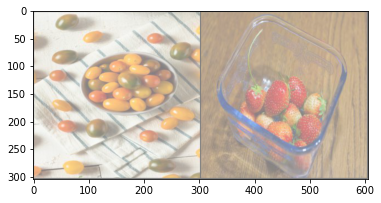

tomato strawberry


In [60]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(desired_batch_size)))

In [61]:
# load the model from file
cnn_model = CNN()
cnn_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [62]:
outputs = cnn_model(images)

In [63]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(desired_batch_size)))

Predicted:  tomato strawberry


In [64]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 900 validation images: {100 * correct // total} %')

Accuracy of the network on the 900 validation images: 54 %


In [65]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = cnn_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cherry is 55.1 %
Accuracy for class: strawberry is 48.3 %
Accuracy for class: tomato is 59.2 %


When the images are normalised Cherry and tomato have good accuracy but strawberry is extremely low.

When the images are not normalised cherry and tomato have less accuracy but strawberry has good accuracy

with 30 epochs accuracies are around 50-60%

In [ ]:
# clean up
del dataiter